In [1]:
import os
import re
import sys
import time
import numpy as np
import pandas as pd
import platform
import getpass
import itertools
from collections import Counter
from datetime import datetime
from typing import Iterable
from typing import List, Optional
import matplotlib.pyplot as plt  

# Functions

In [2]:
def detect_markers_type(df):
    """
    Detects whether markers are microsatellites or SNPs.

    Rule:
      - If any marker contains '/' AND also contains digits > 2 → microsatellites
      - Otherwise → SNPs
    """
    global markers_type

    marker_cols = df.columns[1:]

    # Flatten marker values as strings
    values = df[marker_cols].astype(str).stack()

    # Detect true microsatellite pattern (e.g. 150/158)
    is_micro = values.str.contains(r'\d+\s*/\s*\d+', regex=True).any()

    if is_micro:
        markers_type = "microsatellites"
        print("Type of markers detected: Microsatellites")
    else:
        markers_type = "SNPs"
        print("Type of markers detected: SNPs")

    return markers_type


In [3]:
_IUPAC = {
    'R': ('A', 'G'), 'Y': ('C', 'T'), 'S': ('G', 'C'),
    'W': ('A', 'T'), 'K': ('G', 'T'), 'M': ('A', 'C')
}

def normalize_snp_alleles(genotype):
    """
    Normalize any diploid SNP genotype to a tuple of two alleles.
    Accepts any separator or compact form:
        AA, A/A, A-T, A:T, A;T, A|T, "A;A"
    Returns:
        tuple('A','T') or None if not interpretable as diploid SNP
    """
    if pd.isna(genotype):
        return None
    s = str(genotype).upper()
    # Extract only valid nucleotide alleles, ignore separators
    alleles = re.findall(r'[ACGT]', s)
    if len(alleles) == 2:
        return tuple(alleles)
    return None

In [4]:
def detect_and_convert_markers_to_012(markers_df, sample_size=1000, maf_threshold=0.05):
    """
    Detect marker format and convert SNP-like columns to 0/1/2 encoding when possible.

    Behavior
    --------
    - Keeps first column as ID.
    - Prints detected marker type and explanation.
    - Sets global variable `markers_type`.
    - Optionally applies MAF filtering to SNPs.
    - RETURNS ONLY the converted DataFrame.
    """

    if not isinstance(markers_df, pd.DataFrame):
        raise TypeError("markers_df must be a pandas DataFrame")

    if markers_df.shape[1] == 0:
        raise ValueError("Empty dataframe (no columns).")

    id_col = markers_df.columns[0]
    data_cols = list(markers_df.columns[1:])

    if not data_cols:
        print("No marker columns found (only ID column). Nothing to convert.")
        globals()['markers_type'] = None
        return markers_df.copy()

    # ---- sampling helper ----
    def sample_values():
        stacked = markers_df[data_cols].astype(str).stack()
        if len(stacked) == 0:
            return []
        if len(stacked) <= sample_size:
            return stacked.tolist()
        return stacked.sample(n=sample_size, random_state=1).tolist()

    samples = sample_values()

    # ---- regex patterns ----
    re_numeric_012 = re.compile(r'^[0-2]$')
    re_numeric_01 = re.compile(r'^[01]$')
    re_vcf_gt = re.compile(r'^[01][\/|][01]$')
    re_slash_numeric = re.compile(r'^\s*\d+\s*\/\s*\d+\s*$')
    re_iupac = re.compile(r'^[RYSWKMryswkm]$')

    # ---- detect marker types ----
    counts = Counter()

    for v in samples:
        s = str(v).strip()

        if s == '' or s.lower() in ('nan', 'none'):
            counts['missing'] += 1
            continue

        alleles = re.findall(r'[ACGTacgt]', s)

        if len(alleles) == 2:
            counts['allelic_diploid'] += 1
        elif re_vcf_gt.match(s):
            counts['vcf_gt'] += 1
        elif re_slash_numeric.match(s):
            counts['microsatellite_like'] += 1
        elif re_numeric_012.match(s):
            counts['numeric_012'] += 1
        elif re_numeric_01.match(s):
            counts['numeric_01'] += 1
        elif re_iupac.match(s):
            counts['iupac'] += 1
        else:
            counts['other'] += 1

    most_common_count = counts.most_common(1)[0][1] if counts else 0

    # ---- decide marker type ----
    if counts['microsatellite_like'] and counts['microsatellite_like'] >= most_common_count:
        markers_type = 'microsatellites'
        explanation = "Detected numeric allele sizes (e.g. '150/152')."
    elif counts['vcf_gt'] and counts['vcf_gt'] >= most_common_count:
        markers_type = 'vcf_gt'
        explanation = "Detected VCF GT format (e.g. '0/1')."
    elif counts['numeric_012'] and counts['numeric_012'] >= most_common_count:
        markers_type = 'numeric_012'
        explanation = "Detected numeric SNP encoding (0/1/2)."
    elif counts['allelic_diploid'] and counts['allelic_diploid'] >= most_common_count:
        markers_type = 'allelic_diploid'
        explanation = "Detected diploid SNPs with arbitrary separators."
    elif counts['numeric_01'] and counts['numeric_01'] >= most_common_count:
        markers_type = 'presence_absence'
        explanation = "Detected presence/absence markers (0/1)."
    elif counts['iupac'] and counts['iupac'] >= most_common_count:
        markers_type = 'iupac'
        explanation = "Detected IUPAC ambiguity codes."
    else:
        markers_type = 'unknown'
        explanation = "Could not confidently determine marker format."

    pretty = {
        'microsatellites': 'Microsatellites',
        'vcf_gt': 'VCF GT (0/1)',
        'numeric_012': 'Numeric SNPs (0/1/2)',
        'allelic_diploid': 'Allelic SNPs (any separator)',
        'presence_absence': 'Presence/Absence (0/1)',
        'iupac': 'IUPAC codes',
        'unknown': 'Unknown'
    }

    print(f"Markers type detected: {pretty.get(markers_type, markers_type)}")
    print("Details:", explanation)

    globals()['markers_type'] = markers_type

    # ---- formats not auto-converted ----
    if markers_type in ('microsatellites', 'unknown', 'presence_absence'):
        print("No automatic conversion performed for this marker type.")
        return markers_df.copy()

    # ---- prepare output ----
    df_out = markers_df.copy()

    # ---- column-wise conversion ----
    for col in data_cols:
        col_series = markers_df[col]
        non_null = col_series.dropna().astype(str).str.strip()

        if non_null.empty:
            df_out[col] = np.nan
            continue

        # ---- VCF GT ----
        if non_null.str.match(re_vcf_gt).all():
            def map_vcf(x):
                if pd.isna(x):
                    return np.nan
                a, b = re.split(r'[\/|]', str(x))
                return int(a) + int(b)

            df_out[col] = col_series.map(map_vcf).astype(float)
            continue

        # ---- numeric 0/1/2 ----
        if non_null.str.fullmatch(r'[0-2]').all():
            df_out[col] = pd.to_numeric(col_series, errors='coerce').astype(float)
            continue

        # ---- diploid SNPs ----
        allele_list = []
        for g in non_null:
            norm = normalize_snp_alleles(g)
            if norm:
                allele_list.extend(norm)

        if allele_list:
            allele_counts = Counter(allele_list)

            # monomorphic SNP
            if len(allele_counts) == 1:
                df_out[col] = 0.0
                continue

            ref = allele_counts.most_common(1)[0][0]
            alt = allele_counts.most_common()[-1][0]

            def map_snp(g):
                if pd.isna(g):
                    return np.nan
                norm = normalize_snp_alleles(g)
                if not norm:
                    return np.nan
                return int(norm[0] == alt) + int(norm[1] == alt)

            df_out[col] = col_series.map(map_snp).astype(float)
            continue

        # ---- IUPAC ----
        if non_null.str.fullmatch(r'[RYSWKMryswkm]').all():
            df_out[col] = col_series.map(
                lambda x: 1.0 if str(x).upper() in _IUPAC else np.nan
            ).astype(float)
            continue

        # ---- fallback ----
        coerced = pd.to_numeric(col_series, errors='coerce')
        coerced = coerced.where(coerced.isin([0, 1, 2]), np.nan)
        df_out[col] = coerced.astype(float)
        print(f"Column '{col}': fallback numeric coercion.")

    # ---- MAF FILTER ----
    if markers_type in ('numeric_012', 'vcf_gt', 'allelic_diploid'):
        print(f"Applying MAF filter (threshold = {maf_threshold})...")

        keep_snps = []
        for col in df_out.columns[1:]:
            g = df_out[col].dropna()

            if len(g) < 2 or g.var() == 0:
                continue

            p = g.sum() / (2 * len(g))
            maf_col = min(p, 1 - p)

            if maf_col >= maf_threshold:
                keep_snps.append(col)

        if not keep_snps:
            print("WARNING: No SNPs passed the MAF filter. Returning ID column only.")
            df_out = df_out[[id_col]]
        else:
            df_out = df_out[[id_col] + keep_snps]
            print(f"Retained {len(keep_snps)} SNPs after MAF filtering.")

    print("Conversion complete.")
    print("Global markers_type:", markers_type)

    globals()['df_snps_maf'] = df_out.copy()

    return df_out


In [5]:
def micro_heterozygosity(df, count_nans_as_invalid=True):
    """
    Computes observed and expected heterozygosity per column and the inbreeding
    coefficient F.

    - The FIRST column of df is treated as the sample/individual ID (ignored in calculations).
    - Remaining columns are processed as genotype strings "A/B".
    - Returns: DataFrame with rows ['observed_heterozygosity', 'expected_heterozygosity']
      and a column 'average' (mean across loci).
    - Creates global variables F and heterozygosity_table.

    Notes:
      - NaN cells are excluded from per-column denominators by default. Set
        count_nans_as_invalid=False to include NaNs as invalid entries (denominator = total rows).
    """

    # First column is always treated as ID
    id_col = df.columns[0]

    # All other columns are genotype columns
    cols = [c for c in df.columns if c != id_col]

    observed = {}
    expected = {}

    for col in cols:
        series_raw = df[col]

        # Handle missing values
        if count_nans_as_invalid:
            series = series_raw.dropna().astype(str)
        else:
            series = series_raw.fillna('').astype(str)

        # Keep only valid diploid genotypes (contain "/")
        valid_genotypes = series[series.str.contains("/")]

        if len(valid_genotypes) == 0:
            observed[col] = np.nan
            expected[col] = np.nan
            continue

        # ----------------------------
        # Observed heterozygosity (Ho)
        # ----------------------------
        def is_hetero(cell):
            L, R = cell.split('/', 1)
            return L.strip() != R.strip()

        Ho = valid_genotypes.map(is_hetero).sum() / len(valid_genotypes)
        observed[col] = Ho

        # ----------------------------
        # Expected heterozygosity (He)
        # Based on allele frequencies
        # ----------------------------
        alleles = []

        for cell in valid_genotypes:
            L, R = cell.split('/', 1)
            alleles.extend([L.strip(), R.strip()])

        allele_counts = pd.Series(alleles).value_counts()
        allele_freqs = allele_counts / allele_counts.sum()

        He = 1 - np.sum(allele_freqs ** 2)
        expected[col] = He

    # Build result table
    result = pd.DataFrame(
        [observed, expected],
        index=["observed_heterozygosity", "expected_heterozygosity"]
    )

    result["average"] = result.mean(axis=1)

    # Compute global averages and F
    Ho_avg = result.loc["observed_heterozygosity", cols].mean()
    He_avg = result.loc["expected_heterozygosity", cols].mean()

    F_value = (
        1 - (Ho_avg / He_avg)
        if (He_avg is not None and not np.isnan(He_avg) and He_avg != 0)
        else np.nan
    )

    F_value = round(F_value, 2)

    # Global variables (as in original code)
    globals()['F'] = F_value
    globals()['heterozygosity_table'] = result.round(4)

    # Print only F
    print("Inbreeding coefficient F:", F_value)
    print("")

    return result


In [6]:
def micro_pairwise_relatedness(df, decimals: int = 4) -> pd.DataFrame:
    """
    For every pair of rows in df, compute relatedness = matches / total_possible_elements.
    Returns a DataFrame named r with columns: pair, relatedness.
    Also creates the global object r.

    Behavior:
    - If df is None, uses global df_gen by default (expects df_gen to exist).
    - If df has a column named 'individual', it is used as the individual ID.
      Otherwise, the first column is assumed to contain individual IDs.
    - Pair labels are "ind_i_ind_j".
    - The individual ID column is NOT used for the relatedness calculation.
    """

    # Default to df_gen if no df was passed
    global df_gen
    if df is None:
        df = df_gen

    # Determine which column contains individual identifiers
    if "individual" in df.columns:
        id_col = "individual"
    else:
        # Fallback: assume the first column contains individual IDs
        id_col = df.columns[0]

    # Columns used for relatedness calculation (exclude ID column)
    data_cols = [c for c in df.columns if c != id_col]

    def split_cell(cell: object) -> list:
        if pd.isna(cell):
            return []
        s = str(cell).strip()
        if s == "":
            return []
        return [elem.strip() for elem in s.split(",")]

    results = []
    nrows = len(df)
    row_pairs = list(itertools.combinations(range(nrows), 2))

    # Pre-split cache for data columns only
    split_cache = {
        r_i: {col: split_cell(df.iloc[r_i][col]) for col in data_cols}
        for r_i in range(nrows)
    }

    # Prepare individual names
    individual_names = df[id_col].astype(str).tolist()

    for i, j in row_pairs:
        # Pair label using individual identifiers
        pair_label = f"{individual_names[i]}_{individual_names[j]}"

        total_matches = 0
        total_possible = 0

        for col in data_cols:
            elems_i = split_cache[i][col]
            elems_j = split_cache[j][col]

            max_len = max(len(elems_i), len(elems_j))
            total_possible += max_len

            for k in range(max_len):
                a = elems_i[k] if k < len(elems_i) else None
                b = elems_j[k] if k < len(elems_j) else None
                if a is not None and b is not None and a == b:
                    total_matches += 1

        relatedness = (total_matches / total_possible) if total_possible > 0 else 0.0
        results.append({
            "pair": pair_label,
            "relatedness": round(relatedness, decimals)
        })

    # Export global relatedness
    global r, relatedness_table
    r = pd.DataFrame(results)
    relatedness_table = r
    return r


In [15]:
def snp_heterozygosity(df, count_nans_as_invalid=True):
    """
    Computes observed and expected heterozygosity per column and the inbreeding
    coefficient F.

    Accepts SNP genotypes encoded as:
      0 -> homozygote REF/REF
      1 -> heterozygote REF/ALT
      2 -> homozygote ALT/ALT

    PARAMETERS:
      df: DataFrame with the data
      count_nans_as_invalid: if True, NaNs are excluded from the denominator

    RETURNS:
      DataFrame with Ho and He per locus and average.

    It also creates:
      - global variable F
      - global variable heterozygosity_table
    """
    
    
    if 'df_snps_maf' in globals():
        df = globals()['df_snps_maf']
        
        
    # Automatically use the first column's name as the column to ignore
    ignore_cols = (df.columns[0],)

    cols = [c for c in df.columns if c not in ignore_cols]

    observed = {}
    expected = {}

    for col in cols:
        series_raw = df[col]

        # Denominator based on parameter count_nans_as_invalid
        if count_nans_as_invalid:
            # Exclude NaNs from the denominator
            series_valid = series_raw.dropna()
            total = len(series_valid)
        else:
            # Include NaNs in the denominator
            series_valid = series_raw.dropna()
            total = len(series_raw)

        if total == 0:
            observed[col] = np.nan
            expected[col] = np.nan
            continue

        # Convert entries to 0/1/2 if valid
        def to_int_if_valid(x):
            try:
                if pd.isna(x):
                    return np.nan
                xi = int(x)
                if xi in (0, 1, 2):
                    return xi
                return np.nan
            except Exception:
                return np.nan

        genotypes_valid = series_valid.map(to_int_if_valid).dropna().astype(int)

        # Observed heterozygosity (Ho): proportion of heterozygotes (1)
        n_het = (genotypes_valid == 1).sum()
        Ho = n_het / total if total > 0 else np.nan
        observed[col] = Ho

        # Expected heterozygosity (He): 2*p*q
        n0 = (genotypes_valid == 0).sum()  # homozygote REF/REF
        n1 = (genotypes_valid == 1).sum()  # heterozygote REF/ALT
        n2 = (genotypes_valid == 2).sum()  # homozygote ALT/ALT
        n_valid = n0 + n1 + n2  # number of valid genotypes

        if n_valid == 0:
            He = np.nan
        else:
            # Allele counts: REF allele = 2*n0 + n1 ; ALT allele = 2*n2 + n1
            ref_count = 2 * n0 + n1
            alt_count = 2 * n2 + n1
            denom = 2 * n_valid  # Total number of alleles
            p = ref_count / denom
            q = alt_count / denom
            He = 1 - (p**2 + q**2)  # equivalent to 2*p*q

        expected[col] = He

    # Build final result table
    result = pd.DataFrame(
        [observed, expected],
        index=["observed_heterozygosity", "expected_heterozygosity"]
    )
    result["average"] = result.mean(axis=1)

    # Compute global averages and F
    Ho_avg = result.loc["observed_heterozygosity", cols].mean()
    He_avg = result.loc["expected_heterozygosity", cols].mean()
    F_value = 1 - (Ho_avg / He_avg) if (He_avg is not None and not np.isnan(He_avg) and He_avg != 0) else np.nan
    F_value = round(F_value, 2)
    
    # Create global variable F
    globals()['F'] = F_value

    # Create global variable heterozygosity_table
    globals()['heterozygosity_table'] = result

    print("Inbreeding coefficient F:", F_value)
    print("")

    return result

In [16]:
def snp_pairwise_relatedness(df=None, decimals: int = 4, maf: float = 0.05) -> pd.DataFrame:
    """
    Compute pairwise relatedness as Pearson correlation between individuals
    using SNP genotypes encoded as 0/1/2.

    IMPORTANT CHANGE:
      - Only polymorphic (informative) SNPs are used
      - If SNPs appear already filtered, MAF is not re-applied
      - Prevents zero-variance relatedness matrices

    Notes:
      - First column is treated as the sample ID.
      - Remaining columns are SNPs coded as 0/1/2.
      - Uses pairwise-complete Pearson correlation.
      - Produces global variables r and relatedness_table.
    """

    print("Step 1/6: Checking input dataframe...")
    global df_gen
    if df is None:
        df = df_gen

    if df is None:
        raise ValueError("No dataframe provided and global df_gen is not defined.")

    nrows = len(df)
    if nrows < 2:
        print("Not enough rows to compute pairwise relatedness.")
        r = pd.DataFrame(columns=["pair", "relatedness"])
        globals()['r'] = r
        globals()['relatedness_table'] = r
        return r

    print("Step 2/6: Extracting individual IDs (first column)...")
    id_col = df.columns[0]
    ids = df[id_col].astype(str).tolist()

    print("Step 3/6: Converting SNP data to numeric format...")
    # Convert remaining columns to numeric (0/1/2); invalid values → NaN
    data = df.drop(columns=[id_col]).apply(pd.to_numeric, errors='coerce')

    print("Step 4/6: Applying MAF filter (if needed)...")

    if 'df_snps_maf' in globals():
        print("  SNPs appear already MAF-filtered. Skipping internal MAF filter.")
        data = globals()['df_snps_maf'].drop(columns=[id_col]).apply(pd.to_numeric, errors='coerce')
    else:
        maf_pass_cols = []
        for col in data.columns:
            g = data[col].dropna()
            if g.empty or g.var() == 0:
                continue

            p = g.sum() / (2 * len(g))
            maf_col = min(p, 1 - p)

            if maf_col >= maf:
                maf_pass_cols.append(col)

        data = data[maf_pass_cols]

        if data.shape[1] == 0:
            raise ValueError("No SNPs passed the MAF threshold.")


    print("Step 5/6: Computing correlation matrix (this may take a while)...")
    # Transpose so columns = individuals
    data_T = data.T
    data_T.columns = ids

    corr_matrix = data_T.corr(method='pearson')

    print("Step 6/6: Cleaning correlation matrix and building output...")
    corr_matrix_filled = corr_matrix.fillna(0.0)

    results = []
    cols = corr_matrix_filled.columns.tolist()

    for a, b in itertools.combinations(cols, 2):
        val = corr_matrix_filled.at[a, b]
        results.append({
            "pair": f"{a}_{b}",
            "relatedness": round(float(val), decimals)
        })

    r = pd.DataFrame(results)

    globals()['r'] = r
    globals()['relatedness_table'] = r

    print("Done! Pairwise relatedness successfully computed.")
    return r


In [17]:
def phenotypic_similarity(
    df: Optional[pd.DataFrame],
    trait_cols: Optional[List[str]] = None,
    decimals: int = 4,
) -> pd.DataFrame:
    """
    Compute bounded phenotypic similarity in [0,1] for each trait and each pair of rows,
    using R_k = max_k - min_k (range) for normalization.

    similarity_k(i,j) = (R_k - abs(x_i - x_j)) / R_k

    Behavior:
    - If df is None, the function will try to use a global DataFrame named `mor`.
      If `mor` is not found, a ValueError is raised.
    - If trait_cols is None, numeric columns are auto-selected excluding the FIRST
      column (treated as the sample/individual ID).
    - If R_k == 0 (all values identical) similarity is set to 1 for that trait.
    - If either x_i or x_j is NaN → similarity is NaN for that trait.
    - Output: DataFrame with "pair" column (using values from the FIRST column if present,
      otherwise 1-based indices "i_j") and one column per trait.
    - Final DataFrame is assigned to the global variable `z` and also returned.

    Parameters
    ----------
    df : pd.DataFrame or None
        Input dataframe containing phenotypic trait columns. If None, uses global `mor`.
    trait_cols : list[str] | None
        List of trait column names to use. If None, auto-select numeric columns
        (excluding the first column).
    decimals : int
        Number of decimals to round similarity values.

    Returns
    -------
    pd.DataFrame
        DataFrame named `z` with columns: 'pair' and one column per selected trait.
    """
    # fallback to global 'mor' if df not provided
    if df is None:
        if 'mor' not in globals():
            raise ValueError(
                "df not provided and no global DataFrame named 'mor' found. "
                "Please pass df or create 'mor'."
            )
        df = globals()['mor']

    if not isinstance(df, pd.DataFrame):
        raise TypeError("df must be a pandas DataFrame or None.")

    cols = list(df.columns)
    if len(cols) == 0:
        raise ValueError("Provided DataFrame has no columns.")

    # The FIRST column is treated as the ID column and excluded from trait selection
    id_col = cols[0]
    data_cols = cols[1:]  # candidate trait columns

    # select traits
    if trait_cols is not None:
        if not isinstance(trait_cols, (list, tuple)):
            raise TypeError("trait_cols must be a list/tuple of column names or None.")
        missing = [c for c in trait_cols if c not in cols]
        if missing:
            raise KeyError(f"The following requested columns do not exist in the DataFrame: {missing}")
        # disallow using the id column as a trait
        if id_col in trait_cols:
            raise ValueError(f"The first column ('{id_col}') is treated as ID and cannot be used as a trait.")
        non_numeric = [c for c in trait_cols if not pd.api.types.is_numeric_dtype(df[c])]
        if non_numeric:
            raise TypeError(f"The following columns are not numeric: {non_numeric}")
        selected_traits = list(trait_cols)
    else:
        # auto-select numeric columns excluding the first column
        selected_traits = [c for c in data_cols if pd.api.types.is_numeric_dtype(df[c])]

    if not selected_traits:
        numeric_cols = [c for c in data_cols if pd.api.types.is_numeric_dtype(df[c])]
        raise ValueError(
            "No selectable traits found (selected_traits is empty). "
            f"Numeric columns available (excluding first column '{id_col}'): {numeric_cols}."
        )

    # compute ranges = max - min for the selected traits
    ranges = df[selected_traits].max() - df[selected_traits].min()
    ranges = ranges[selected_traits]  # ensure same order/index

    results = []
    nrows = len(df)

    # prepare individual names (use the values from the first column; fallback to 1-based indices)
    id_values = df.iloc[:, 0].astype(str).tolist()
    use_ids = True  # we always have a first column to use as label

    for i, j in itertools.combinations(range(nrows), 2):
        if use_ids:
            ind_i = id_values[i]
            ind_j = id_values[j]
            pair_label = f"{ind_i}_{ind_j}"
        else:
            pair_label = f"{i+1}_{j+1}"

        row = {"pair": pair_label}
        for col in selected_traits:
            xi = df.iloc[i][col]
            xj = df.iloc[j][col]
            R = ranges.loc[col]

            if pd.isna(xi) or pd.isna(xj):
                sim = float("nan")
            else:
                diff = abs(xi - xj)
                if pd.isna(R) or R == 0:
                    sim = 1.0
                else:
                    sim = (R - diff) / R
                    # clip to [0,1]
                    if sim < 0:
                        sim = 0.0
                    elif sim > 1:
                        sim = 1.0

            row[col] = round(sim, decimals) if pd.notna(sim) else sim

        results.append(row)

    # create and export global z
    global z, phenotypic_similarity_table, traits_stats
    z = pd.DataFrame(results)
    phenotypic_similarity_table = z
    traits_stats = df.describe().round(2)
    return z


In [18]:
def heritability(
    r_df: Optional[pd.DataFrame] = None,
    z_df: Optional[pd.DataFrame] = None,
    r_col: str = "relatedness",
    key: str = "pair",
    F: Optional[float] = None,
    ddof: int = 0,
    n_bootstrap: int = 1000,
    ci: float = 0.95,
    random_state: Optional[int] = None
) -> pd.DataFrame:
    """
    Computes per-trait heritability with bootstrap standard errors and confidence intervals.

    Behavior:
      - If r_df is None, tries to use global variable `r`.
      - If z_df is None, tries to use global variable `z`.
      - If F is provided by the user, that value is always used.
      - If F is None, tries to use global variable `F`.
      - Raises ValueError with clear message if any required input is missing.

    Returns a DataFrame with columns:
      - trait
      - heritability (point estimate)
      - standard_error (bootstrap SE)
      - ci_lower (bootstrap percentile CI)
      - ci_upper

    Also assigns the returned DataFrame to:
      - global `heritability_table`
      - global `heritability_table_F_<F>`
    """

    # --- fallback to globals if not provided ---
    if r_df is None:
        if 'r' in globals():
            r_df = globals()['r']
        else:
            raise ValueError("r_df not provided and no global 'r' found. Please pass r_df or create global 'r'.")

    if z_df is None:
        if 'z' in globals():
            z_df = globals()['z']
        else:
            raise ValueError("z_df not provided and no global 'z' found. Please pass z_df or create global 'z'.")

    # If F is explicitly provided by the user, use it.
    # Otherwise, fall back to the global F if available.
    if F is None:
        if 'F' in globals():
            F = globals()['F']
        else:
            raise ValueError("F not provided and no global 'F' found. Please pass F or run heterozygosity() first.")
    F = float(F)

    # ------------ Merge ----------------------
    merged = pd.merge(r_df[[key, r_col]], z_df, on=key, how="inner")
    if merged.empty:
        raise ValueError("Merge resulted in empty dataframe. Check keys in r_df and z_df.")

    n_pairs = merged.shape[0]

    # ------------ Extract and validate r ------
    r = pd.to_numeric(merged[r_col], errors="coerce")
    if r.isna().any():
        raise ValueError(f"Non-numeric values found in relatedness column '{r_col}'.")

    var_r = r.var(ddof=ddof)
    if var_r == 0 or np.isclose(var_r, 0):
        raise ValueError("Variance of relatedness is zero; cannot compute heritability.")

    # ------------ Trait columns ---------------
    trait_cols = [c for c in merged.columns if c not in {key, r_col}]
    if not trait_cols:
        raise ValueError("No trait columns found after merging r_df and z_df.")

    # ------------ Center data -----------------
    r_centered = r - r.mean()
    z = merged[trait_cols].apply(pd.to_numeric, errors="coerce")
    if z.isna().any().any():
        raise ValueError("Non-numeric values detected in trait columns after conversion.")
    z_centered = z - z.mean()

    # ------------ Point estimates --------------
    covariances = (r_centered.values.reshape(-1, 1) * z_centered.values).mean(axis=0)
    h2_unadjusted = covariances / (2.0 * var_r)
    h2_point = h2_unadjusted * (1.0 + F)

    # ------------ Bootstrap --------------------
    rng = np.random.default_rng(random_state)
    B = int(n_bootstrap)
    boot_estimates = np.full((B, len(trait_cols)), np.nan)

    for b in range(B):
        idx = rng.integers(0, n_pairs, size=n_pairs)
        r_s = r.values[idx]
        z_s = z.values[idx, :]

        var_r_s = np.var(r_s, ddof=ddof)
        if var_r_s == 0 or np.isclose(var_r_s, 0):
            continue

        r_s_centered = r_s - r_s.mean()
        z_s_centered = z_s - z_s.mean(axis=0)

        cov_s = (r_s_centered.reshape(-1, 1) * z_s_centered).mean(axis=0)
        h2_unadj_s = cov_s / (2.0 * var_r_s)
        h2_s = h2_unadj_s * (1.0 + F)

        boot_estimates[b, :] = h2_s

    # Remove invalid bootstrap iterations
    valid = ~np.all(np.isnan(boot_estimates), axis=1)
    boot_valid = boot_estimates[valid]

    if boot_valid.shape[0] == 0:
        raise RuntimeError("All bootstrap replicates invalid (variance of r was zero in all replicates).")

    # ------------ Standard errors + CI ---------
    se = np.nanstd(boot_valid, axis=0, ddof=1)

    alpha = (1 - ci) / 2
    ci_lower = np.nanpercentile(boot_valid, 100 * alpha, axis=0)
    ci_upper = np.nanpercentile(boot_valid, 100 * (1 - alpha), axis=0)

    # ------------ Final output -----------------
    out = pd.DataFrame({
        "trait": trait_cols,
        "heritability": h2_point,
        "standard_error": se,
        "ci_lower": ci_lower,
        "ci_upper": ci_upper
    }).round(4)

    # Always keep the default global name (backward compatibility)
    globals()['heritability_table'] = out

    # Also assign a global name that includes the value of F
    F_label = str(F).replace('.', '_')
    globals()[f'heritability_table_F_{F_label}'] = out

    print('n_bootstrap:', n_bootstrap)
    print('')
    print(f'heritability_table_F_{F}:')
    print('')
    print('='*70)
    print(out)
    print('-'*70)
    #return out


# Compilation

In [19]:
def h2(markers, traits):
    """
    High-level pipeline to compute:
      1. Marker preprocessing (once)
      2. Heterozygosity
      3. Pairwise relatedness
      4. Phenotypic similarity
      5. Heritability (h²)
    """

    # ------------------------------------------------
    # Clean previous h2 globals
    # ------------------------------------------------
    h2_globals = [
        'heterozygosity_table',
        'relatedness_table',
        'phenotypic_similarity_table',
        'heritability_table',
        'traits_stats',
        'F',
        'r'
    ]

    for k in h2_globals:
        if k in globals():
            del globals()[k]

    # Remove dynamic heritability tables
    for k in list(globals().keys()):
        if k.startswith('heritability_table_F_'):
            del globals()[k]

    # Remove internal h2 cache variables
    for k in list(globals().keys()):
        if k.startswith('_h2_'):
            del globals()[k]

    # ------------------------------------------------
    # Timing
    # ------------------------------------------------
    start_time = time.time()

    # Store raw inputs (reproducibility)
    globals()['_h2_markers_input'] = markers.copy()
    globals()['_h2_traits_input'] = traits.copy()

    # ------------------------------------------------
    # STEP 0: Detect marker type FIRST
    # ------------------------------------------------
    print("Step 0/5: Detecting marker type...")

    markers_type = detect_markers_type(markers)
    globals()['_h2_markers_type'] = markers_type

    # ------------------------------------------------
    # STEP 1: Preprocess markers ONCE
    # ------------------------------------------------
    print("Step 1/5: Preprocessing markers...")

    if markers_type == 'microsatellites':
        # Microsatellites must NOT be converted or MAF-filtered
        markers_processed = markers.copy()

    elif markers_type == 'SNPs':
        # SNPs are converted and MAF-filtered exactly once
        markers_processed = detect_and_convert_markers_to_012(markers)

    else:
        raise ValueError(
            f"Unrecognized markers_type '{markers_type}'.\n\n"
            "Valid marker types:\n"
            "  • microsatellites → cells contain '/', e.g. '150/158'\n"
            "  • SNPs            → numeric or allele codes without '/', e.g. 0/1/2\n"
        )

    globals()['_h2_markers_processed'] = markers_processed

    # ------------------------------------------------
    # STEP 2: Marker-based statistics
    # ------------------------------------------------
    print("Step 2/5: Computing marker-based statistics...")

    if markers_type == 'microsatellites':
        micro_heterozygosity(markers_processed)
        micro_pairwise_relatedness(markers_processed)

    elif markers_type == 'SNPs':
        snp_heterozygosity(markers_processed)
        snp_pairwise_relatedness(markers_processed)

    # ------------------------------------------------
    # STEP 3: Phenotypic similarity
    # ------------------------------------------------
    print("Step 3/5: Computing phenotypic similarity...")

    phenotypic_similarity(traits)

    # ------------------------------------------------
    # STEP 4: Heritability
    # ------------------------------------------------
    print("Step 4/5: Computing heritability...")

    heritability()

    # ------------------------------------------------
    # Timing and summary
    # ------------------------------------------------
    elapsed_time = time.time() - start_time
    globals()['_h2_runtime_seconds'] = elapsed_time

    print("")
    print("h2 pipeline completed successfully.")
    print(f"Total computation time: {elapsed_time:.2f} seconds")
    print("")
    print("Available results:")
    print("  traits_stats")
    print("  heterozygosity_table")
    print("  F")
    print("  relatedness_table")
    print("  phenotypic_similarity_table")
    print("  heritability_table")
    print("")
    print("To recalculate heritability with a different F value:")
    print("  heritability(F=value)")
    print("")
    print("To save all data:")
    print("  save_run()")


In [20]:
def save_run():
    """
    Save results into a timestamped folder inside a base 'output' directory.
    
    Saves:
      - Heritability tables
      - Raw and processed inputs
      - Processed markers
      - Clean, organized metadata with enriched genetic summary
    """
   
    # -------------------------------
    # Ensure base 'output' directory exists
    # -------------------------------
    base_dir = "output"
    os.makedirs(base_dir, exist_ok=True)

    # -------------------------------
    # Create subfolder with timestamp
    # -------------------------------
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    folder_name = os.path.join(base_dir, f"heritable_run_{timestamp}")
    os.makedirs(folder_name, exist_ok=True)

    # -------------------------------
    # Save main tables
    # -------------------------------
    heritability_table.to_csv(f"{folder_name}/heritability_table.csv", index=False)
    heterozygosity_table.to_csv(f"{folder_name}/heterozygosity_table.csv", index=True)
    relatedness_table.to_csv(f"{folder_name}/relatedness_table.csv", index=False)
    phenotypic_similarity_table.to_csv(f"{folder_name}/phenotypic_similarity_table.csv", index=False)

    # Save all heritability tables with explicit F values
    for name, obj in globals().items():
        if name.startswith("heritability_table_F_") and isinstance(obj, pd.DataFrame):
            obj.to_csv(f"{folder_name}/{name}.csv", index=False)

    # -------------------------------
    # Save raw and processed inputs
    # -------------------------------
    raw_markers_path = processed_markers_path = None
    n_markers_initial = n_markers_used = n_individuals = None

    if '_h2_markers_input' in globals():
        raw_markers_path = f"{folder_name}/input_markers_raw.csv"
        globals()['_h2_markers_input'].to_csv(raw_markers_path, index=False)
        n_markers_initial = globals()['_h2_markers_input'].shape[1] - 1  # minus ID

    if '_h2_markers_processed' in globals():
        processed_markers_path = f"{folder_name}/markers_processed.csv"
        globals()['_h2_markers_processed'].to_csv(processed_markers_path, index=False)
        n_markers_used = globals()['_h2_markers_processed'].shape[1] - 1
        n_individuals = globals()['_h2_markers_processed'].shape[0]

    # -------------------------------
    # Build metadata as mini-report
    # -------------------------------
    lines = []

    # Markers info
    lines.append("[Markers Info]")
    if '_h2_markers_type' in globals():
        marker_type = globals()['_h2_markers_type']
        lines.append(f"markers_type: {marker_type}")
    if n_individuals is not None:
        lines.append(f"n_individuals: {n_individuals}")
    if n_markers_initial is not None:
        lines.append(f"n_markers_initial: {n_markers_initial}")
    if n_markers_used is not None:
        lines.append(f"n_markers_used: {n_markers_used}")
    
    # Only record MAF if marker type is SNPs
    if marker_type.lower() == "snps":
        maf = 0.05 if 'maf_threshold' not in globals() else globals()['maf_threshold']
        lines.append(f"maf_threshold: {maf}")
    lines.append("")

    # Heritability parameters
    lines.append("[Heritability Parameters]")
    lines.append(f"n_bootstrap: {1000 if 'n_bootstrap' not in globals() else globals()['n_bootstrap']}")
    lines.append(f"ci: {0.95 if 'ci' not in globals() else globals()['ci']}")
    lines.append(f"ddof: {0 if 'ddof' not in globals() else globals()['ddof']}")
    lines.append("")

    # Genetic summary
    lines.append("[Genetic Summary]")
    if 'F' in globals():
        lines.append(f"inbreeding_coefficient_F: {globals()['F']}")
    if 'heterozygosity_table' in globals():
        ht = globals()['heterozygosity_table']
        if 'average' in ht.columns:
            lines.append(f"average_observed_heterozygosity: {ht.loc['observed_heterozygosity','average']:.4f}")
            lines.append(f"average_expected_heterozygosity: {ht.loc['expected_heterozygosity','average']:.4f}")
    lines.append("")

    # Runtime and system
    lines.append("[Runtime & System]")
    if '_h2_runtime_seconds' in globals():
        lines.append(f"runtime_seconds: {round(globals()['_h2_runtime_seconds'],4)}")
    lines.append(f"python_version: {sys.version.replace(chr(10),' ')}")
    lines.append(f"platform: {platform.platform()}")
    lines.append(f"user: {getpass.getuser()}")
    lines.append("")

    # Write to file
    metadata_path = f"{folder_name}/run_metadata.csv"
    with open(metadata_path, "w", encoding="utf-8") as f:
        for line in lines:
            f.write(line + "\n")

    print(f"Files successfully saved in: {folder_name}")
    print("Metadata saved as a clean mini-report with enriched genetic summary.")

    return folder_name


# Tests

### Chili - microsatellites

In [13]:
markers = pd.read_csv('./chili/gen.csv') # markers = pd.read_csv('./data/chili/chili/gen.csv') 
traits = pd.read_csv('./chili/mor.csv') # traits = pd.read_csv('./data/chili/chili/mor.csv')  # mh2.h2(markers, traits)

In [14]:
markers

,individual,Bd12,Ng10,Ng18,Ng20,Ng6,Ng7,Ng8
0,ind_1,2/2,1/1,4/4,1/1,2/2,0/0,2/2
1,ind_2,2/2,1/1,4/4,1/1,2/2,0/0,2/2
2,ind_3,2/2,1/1,3/3,1/1,2/2,2/2,2/2
3,ind_4,2/2,1/1,4/4,1/1,2/2,2/2,2/2
4,ind_5,2/2,1/1,4/4,1/1,2/2,2/2,2/2
...,...,...,...,...,...,...,...,...
109,ind_110,2/2,2/2,2/2,1/1,1/1,3/3,1/1
110,ind_111,0/0,2/2,2/2,1/1,1/1,3/3,1/1
111,ind_112,1/1,2/2,2/2,1/1,1/1,3/3,1/1
112,ind_113,1/1,2/2,2/2,1/1,1/1,3/3,1/1


In [15]:
traits

,individual,stem_width,stem_height,first_flower_day,fruits_number,fruit_length,fruit_diameter,fruit_weight,seeds_number,yield
0,ind_1,1.52,78.0,44.0,13,23.18,3.39,48.08,135.00,624.98
1,ind_2,1.36,74.0,45.0,9,25.05,3.08,48.10,164.00,432.90
2,ind_3,1.43,69.0,63.0,8,17.75,2.03,19.05,47.00,152.40
3,ind_4,1.53,68.0,44.0,12,21.50,3.04,46.58,156.00,558.90
4,ind_5,1.34,84.0,44.0,6,24.88,3.38,54.05,148.33,324.30
...,...,...,...,...,...,...,...,...,...,...
109,ind_110,1.29,45.0,83.0,0,3.69,2.59,8.25,51.64,0.00
110,ind_111,0.77,33.0,57.0,0,3.69,2.59,8.25,51.64,0.00
111,ind_112,1.52,59.0,69.0,0,3.69,2.59,8.25,51.64,0.00
112,ind_113,1.04,37.5,52.0,10,3.29,2.53,6.70,49.00,67.00


In [16]:
h2(markers,traits)

Step 0/5: Detecting marker type...
Type of markers detected: Microsatellites
Step 1/5: Preprocessing markers...
Step 2/5: Computing marker-based statistics...
Inbreeding coefficient F: 1.0

Step 3/5: Computing phenotypic similarity...
Step 4/5: Computing heritability...
n_bootstrap: 1000

heritability_table_F_1.0:

              trait  heritability  standard_error  ci_lower  ci_upper
0        stem_width        0.0911          0.0072    0.0772    0.1054
1       stem_height        0.1483          0.0068    0.1356    0.1618
2  first_flower_day        0.2005          0.0073    0.1867    0.2148
3     fruits_number        0.1388          0.0103    0.1177    0.1586
4      fruit_length        0.9343          0.0087    0.9179    0.9509
5    fruit_diameter        0.4437          0.0103    0.4237    0.4635
6      fruit_weight        0.7902          0.0089    0.7726    0.8069
7      seeds_number        0.6425          0.0083    0.6268    0.6587
8             yield        0.1907          0.0084    

In [17]:
save_run()

Files successfully saved in: output\heritable_run_2026-01-29_10-06-45
Metadata saved as a clean mini-report with enriched genetic summary.


'output\\heritable_run_2026-01-29_10-06-45'

## Maize -SNPs

In [17]:
markers = pd.read_csv('./maize/maize_markers.csv')
traits = pd.read_csv('./maize/maize_mean_pheno.csv')

In [18]:
h2(markers,traits)

Type of markers detected: SNPs
Inbreeding coefficient F: 0.97

Step 1/7: Checking input dataframe...
Step 2/7: Extracting individual IDs (first column)...
Step 3/7: Converting SNP data to numeric format...
Step 4/7: Applying MAF filter...
  Retained 41722 SNPs after MAF filtering.
Step 5/7: Computing correlation matrix (this may take a while)...
Step 6/7: Cleaning correlation matrix (replacing NaN with 0.0)...
Step 7/7: Building pairwise relatedness output...
Done! Pairwise relatedness successfully computed.
n_bootstrap: 1000

heritability_table_F_0.97:

           trait  heritability  standard_error  ci_lower  ci_upper
0    grain.yield        0.2160          0.0078    0.2013    0.2318
1   grain.number        0.1712          0.0083    0.1563    0.1879
2      seed.size        0.1142          0.0070    0.1003    0.1279
3       anthesis        0.2045          0.0086    0.1881    0.2209
4        silking        0.2146          0.0081    0.1986    0.2297
5   plant.height        0.0468       

# Mice - SNPs

In [21]:
markers = pd.read_csv('./mice/mice_markers.csv')
traits = pd.read_csv('./mice/mice_traits.csv')

In [22]:
h2(markers,traits)

Step 0/5: Detecting marker type...
Type of markers detected: SNPs
Step 1/5: Preprocessing markers...
Markers type detected: Numeric SNPs (0/1/2)
Details: Detected numeric SNP encoding (0/1/2).
Applying MAF filter (threshold = 0.05)...
Retained 10339 SNPs after MAF filtering.
Conversion complete.
Global markers_type: numeric_012
Step 2/5: Computing marker-based statistics...
Inbreeding coefficient F: 0.03

Step 1/6: Checking input dataframe...
Step 2/6: Extracting individual IDs (first column)...
Step 3/6: Converting SNP data to numeric format...
Step 4/6: Applying MAF filter (if needed)...
  SNPs appear already MAF-filtered. Skipping internal MAF filter.
Step 5/6: Computing correlation matrix (this may take a while)...
Step 6/6: Cleaning correlation matrix and building output...
Done! Pairwise relatedness successfully computed.
Step 3/5: Computing phenotypic similarity...
Step 4/5: Computing heritability...
n_bootstrap: 1000

heritability_table_F_0.03:

                trait  heritabil

In [23]:
save_run()

Files successfully saved in: output\heritable_run_2026-01-29_10-46-46
Metadata saved as a clean mini-report with enriched genetic summary.


'output\\heritable_run_2026-01-29_10-46-46'

# Ramphocelus spp. - Microsatellites

## R. dimidiatus

In [13]:
markers_RD = pd.read_csv('./ramphocelus/R_dimidiatus/markers_RD.csv')
traits_RD = pd.read_csv('./ramphocelus/R_dimidiatus/traits_RD.csv')

In [14]:
h2(markers_RD, traits_RD)

Step 0/5: Detecting marker type...
Type of markers detected: Microsatellites
Step 1/5: Preprocessing markers...
Step 2/5: Computing marker-based statistics...
Inbreeding coefficient F: 0.14

Step 3/5: Computing phenotypic similarity...
Step 4/5: Computing heritability...
n_bootstrap: 1000

heritability_table_F_0.14:

              trait  heritability  standard_error  ci_lower  ci_upper
0        bird_width       -0.0213          0.0647   -0.1511    0.1019
1  bird_TotalLength        0.0682          0.0532   -0.0391    0.1665
2     bird_wingspan        0.0100          0.0638   -0.1230    0.1279
3         bird_wing        0.0685          0.0478   -0.0181    0.1621
4         bird_tail        0.0846          0.0469   -0.0130    0.1795
5       bird_tarsus       -0.0497          0.0637   -0.1843    0.0784
6       bird_finger       -0.0777          0.1175   -0.3162    0.1456
7       beak_culmen        0.0413          0.0526   -0.0729    0.1420
8        beak_width        0.1047          0.0567  

In [15]:
save_run()

Files successfully saved in: output\heritable_run_2026-01-26_11-36-17
Metadata saved as a clean mini-report with enriched genetic summary.


'output\\heritable_run_2026-01-26_11-36-17'

## R. icteronotus

In [16]:
markers_RI = pd.read_csv('./ramphocelus/R_icteronotus/markers_RI.csv')
traits_RI = pd.read_csv('./ramphocelus/R_icteronotus/traits_RI.csv')

In [17]:
h2(markers_RI, traits_RI)

Step 0/5: Detecting marker type...
Type of markers detected: Microsatellites
Step 1/5: Preprocessing markers...
Step 2/5: Computing marker-based statistics...
Inbreeding coefficient F: 0.08

Step 3/5: Computing phenotypic similarity...
Step 4/5: Computing heritability...
n_bootstrap: 1000

heritability_table_F_0.08:

              trait  heritability  standard_error  ci_lower  ci_upper
0        bird_width       -0.0849          0.0650   -0.2070    0.0446
1  bird_TotalLength        0.0221          0.0457   -0.0657    0.1114
2     bird_wingspan        0.0408          0.0518   -0.0709    0.1340
3         bird_wing        0.0203          0.0620   -0.1084    0.1352
4         bird_tail        0.0303          0.0519   -0.0772    0.1261
5       bird_tarsus        0.0785          0.0446   -0.0047    0.1627
6       bird_finger        0.1363          0.0874   -0.0445    0.2890
7       beak_culmen       -0.0242          0.0596   -0.1442    0.0848
8        beak_width       -0.0617          0.0635  

In [18]:
save_run()

Files successfully saved in: output\heritable_run_2026-01-26_11-36-29
Metadata saved as a clean mini-report with enriched genetic summary.


'output\\heritable_run_2026-01-26_11-36-29'

## Combined

In [23]:
markers_RIRD = pd.read_csv('./ramphocelus/Combinados/markers_RIRD.csv')
traits_RIRD = pd.read_csv('./ramphocelus/Combinados/traits_RIRD.csv')

In [24]:
h2(markers_RIRD, traits_RIRD)

Step 0/5: Detecting marker type...
Type of markers detected: Microsatellites
Step 1/5: Preprocessing markers...
Step 2/5: Computing marker-based statistics...
Inbreeding coefficient F: 0.16

Step 3/5: Computing phenotypic similarity...
Step 4/5: Computing heritability...
n_bootstrap: 1000

heritability_table_F_0.16:

              trait  heritability  standard_error  ci_lower  ci_upper
0        bird_width       -0.0718          0.0474   -0.1675    0.0192
1  bird_TotalLength        0.0842          0.0227    0.0413    0.1287
2     bird_wingspan        0.0311          0.0264   -0.0236    0.0831
3         bird_wing       -0.0005          0.0305   -0.0621    0.0584
4         bird_tail        0.0637          0.0221    0.0193    0.1042
5       bird_tarsus        0.0503          0.0328   -0.0138    0.1148
6       bird_finger        0.0224          0.0696   -0.1271    0.1478
7       beak_culmen       -0.0191          0.0316   -0.0803    0.0407
8        beak_width        0.0797          0.0319  

In [25]:
 save_run()

Files successfully saved in: output\heritable_run_2026-01-26_11-41-13
Metadata saved as a clean mini-report with enriched genetic summary.


'output\\heritable_run_2026-01-26_11-41-13'

# Wild chili

### Data load

In [13]:
traits = pd.read_csv('./chili/wild/traits_merged.csv')
micros = pd.read_csv('./chili/wild/micros_merged.csv')
snps = pd.read_csv('./chili/wild/snps_merged.csv')

In [14]:
traits = traits.iloc[:,:-1]

In [15]:
h2(micros,traits)

Step 0/5: Detecting marker type...
Type of markers detected: Microsatellites
Step 1/5: Preprocessing markers...
Step 2/5: Computing marker-based statistics...
Inbreeding coefficient F: 1.0

Step 3/5: Computing phenotypic similarity...
Step 4/5: Computing heritability...
n_bootstrap: 1000

heritability_table_F_1.0:

             trait  heritability  standard_error  ci_lower  ci_upper
0  flower_diameter        0.1229          0.0508    0.0281    0.2278
1     fruit_weight       -0.0757          0.0641   -0.2227    0.0308
2     fruit_length        0.0307          0.0653   -0.1035    0.1493
3      fruit_width        0.0040          0.0660   -0.1331    0.1220
4     fruit_height        0.3056          0.0655    0.1814    0.4286
----------------------------------------------------------------------

h2 pipeline completed successfully.
Total computation time: 0.46 seconds

Available results:
  traits_stats
  heterozygosity_table
  F
  relatedness_table
  phenotypic_similarity_table
  heritabili

In [16]:
save_run()

Files successfully saved in: output\heritable_run_2026-01-28_08-41-52
Metadata saved as a clean mini-report with enriched genetic summary.


'output\\heritable_run_2026-01-28_08-41-52'

In [17]:
relatedness_table

,pair,relatedness
0,B-4_B-7,0.5
1,B-4_B-9B,0.6
2,B-4_C-1,0.7
3,B-4_C-2,0.4
4,B-4_C-alfa,0.8
...,...,...
346,G-21_H-33,0.6
347,G-21_C-9,0.3
348,H-29_H-33,0.3
349,H-29_C-9,0.4


In [18]:
r_micro = relatedness_table

In [19]:
h2(snps, traits)

Step 0/5: Detecting marker type...
Type of markers detected: SNPs
Step 1/5: Preprocessing markers...
Markers type detected: Allelic SNPs (any separator)
Details: Detected diploid SNPs with arbitrary separators.
Applying MAF filter (threshold = 0.05)...
Retained 131 SNPs after MAF filtering.
Conversion complete.
Global markers_type: allelic_diploid
Step 2/5: Computing marker-based statistics...
Inbreeding coefficient F: 0.74

Step 1/6: Checking input dataframe...
Step 2/6: Extracting individual IDs (first column)...
Step 3/6: Converting SNP data to numeric format...
Step 4/6: Applying MAF filter (if needed)...
  SNPs appear already MAF-filtered. Skipping internal MAF filter.
Step 5/6: Computing correlation matrix (this may take a while)...
Step 6/6: Cleaning correlation matrix and building output...
Done! Pairwise relatedness successfully computed.
Step 3/5: Computing phenotypic similarity...
Step 4/5: Computing heritability...
n_bootstrap: 1000

heritability_table_F_0.74:

            

In [20]:
save_run()

Files successfully saved in: output\heritable_run_2026-01-28_08-46-14
Metadata saved as a clean mini-report with enriched genetic summary.


'output\\heritable_run_2026-01-28_08-46-14'

In [70]:
r_snps = relatedness_table

In [71]:
r_micro

,pair,relatedness
0,B-4_B-7,0.5
1,B-4_B-9B,0.6
2,B-4_C-1,0.7
3,B-4_C-2,0.4
4,B-4_C-alfa,0.8
...,...,...
346,G-21_H-33,0.6
347,G-21_C-9,0.3
348,H-29_H-33,0.3
349,H-29_C-9,0.4


In [72]:
r_snps # bif

,pair,relatedness
0,B-4_B-7,-0.1604
1,B-4_B-9B,-0.1869
2,B-4_C-1,0.7179
3,B-4_C-2,-0.0688
4,B-4_C-alfa,-0.1577
...,...,...
346,G-21_H-33,0.8083
347,G-21_C-9,-0.2733
348,H-29_H-33,-0.2878
349,H-29_C-9,0.8849


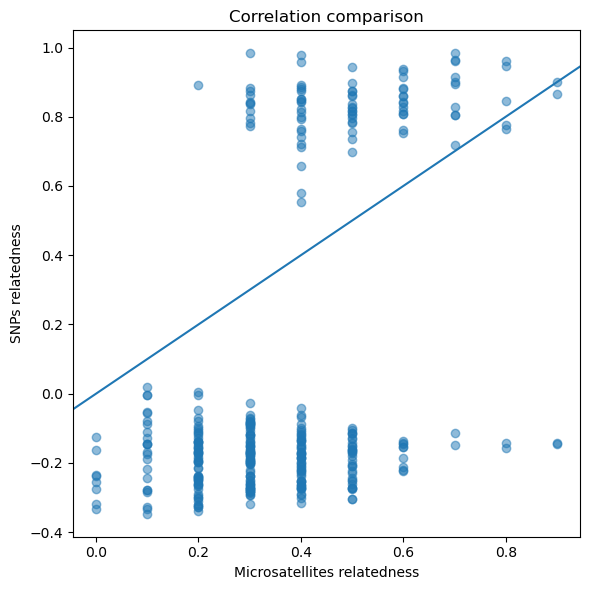

In [73]:
# MAF + ibs
x = r_micro['relatedness'].values.flatten()
y = r_snps['relatedness'].values.flatten()

# Quitar NaN
mask = ~np.isnan(x) & ~np.isnan(y)
x = x[mask]
y = y[mask]

plt.figure(figsize=(6, 6))
plt.scatter(x, y, alpha=0.5)
plt.xlabel("Microsatellites relatedness")
plt.ylabel("SNPs relatedness")
plt.title("Correlation comparison")
plt.axline((0, 0), slope=1)
plt.tight_layout()
plt.show()

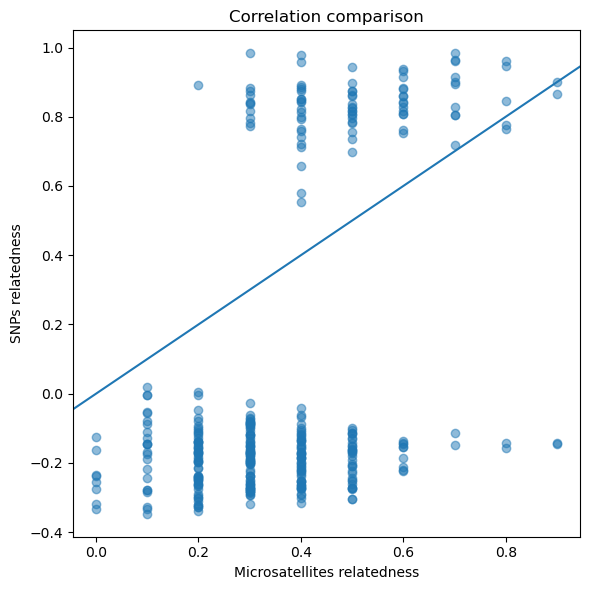

In [74]:
# Normal
x = r_micro['relatedness'].values.flatten()
y = r_snps['relatedness'].values.flatten()

# Quitar NaN
mask = ~np.isnan(x) & ~np.isnan(y)
x = x[mask]
y = y[mask]

plt.figure(figsize=(6, 6))
plt.scatter(x, y, alpha=0.5)
plt.xlabel("Microsatellites relatedness")
plt.ylabel("SNPs relatedness")
plt.title("Correlation comparison")
plt.axline((0, 0), slope=1)
plt.tight_layout()
plt.show()


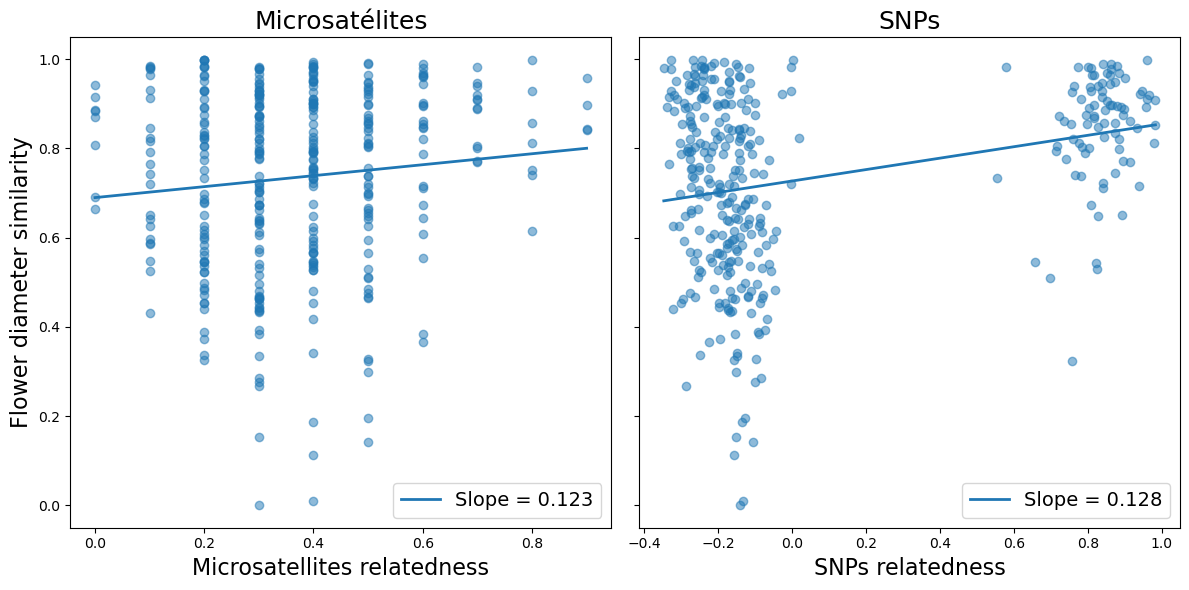

In [75]:
# Phenotype
y = phenotypic_similarity_table['flower_diameter'].values.flatten()

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# ======================
# Panel 1: Microsatélites
# ======================
x_micro = r_micro['relatedness'].values.flatten()

mask = ~np.isnan(x_micro) & ~np.isnan(y)
xm = x_micro[mask]
ym = y[mask]

slope_m, intercept_m = np.polyfit(xm, ym, 1)
x_line = np.array([xm.min(), xm.max()])
y_line = slope_m * x_line + intercept_m

axes[0].scatter(xm, ym, alpha=0.5)
axes[0].plot(x_line, y_line, linewidth=2, label=f"Slope = {slope_m:.3f}")
axes[0].set_xlabel("Microsatellites relatedness", fontsize=16)
axes[0].set_ylabel("Flower diameter similarity", fontsize=16)
axes[0].set_title("Microsatélites", fontsize=18)
axes[0].legend(fontsize=14)

# ======================
# Panel 2: SNPs
# ======================
x_snps = r_snps['relatedness'].values.flatten()

mask = ~np.isnan(x_snps) & ~np.isnan(y)
xs = x_snps[mask]
ys = y[mask]

slope_s, intercept_s = np.polyfit(xs, ys, 1)
x_line = np.array([xs.min(), xs.max()])
y_line = slope_s * x_line + intercept_s

axes[1].scatter(xs, ys, alpha=0.5)
axes[1].plot(x_line, y_line, linewidth=2, label=f"Slope = {slope_s:.3f}")
axes[1].set_xlabel("SNPs relatedness", fontsize=16)
axes[1].set_title("SNPs", fontsize=18)
axes[1].legend(fontsize=14)

plt.tight_layout()
plt.show()


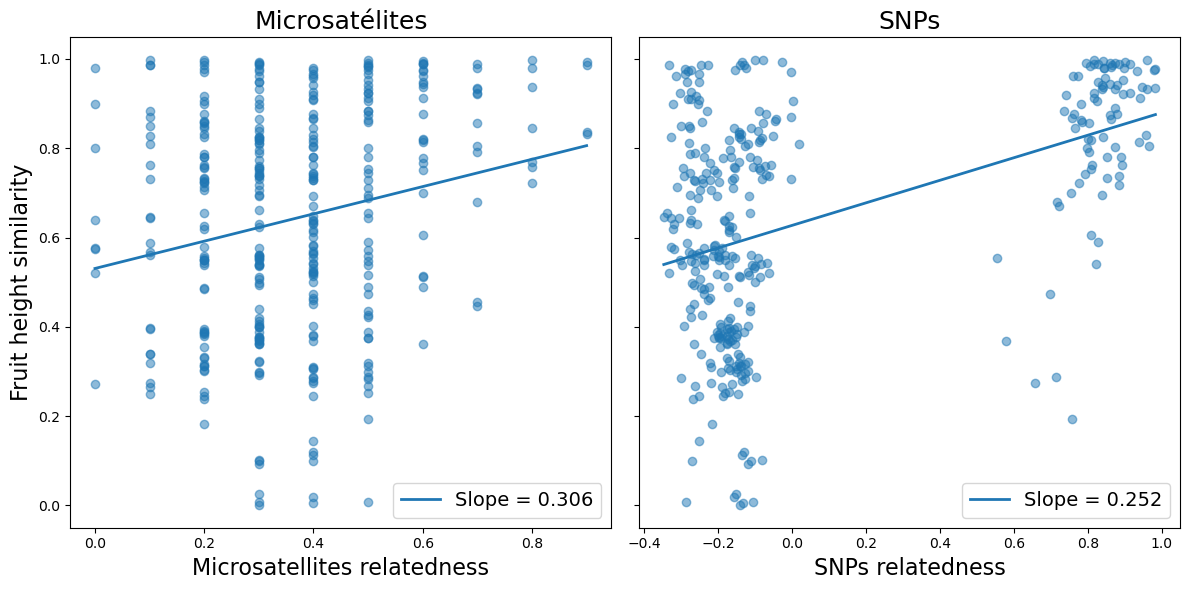

In [76]:
# Phenotype
y = phenotypic_similarity_table['fruit_height'].values.flatten()

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# ======================
# Panel 1: Microsatélites
# ======================
x_micro = r_micro['relatedness'].values.flatten()

mask = ~np.isnan(x_micro) & ~np.isnan(y)
xm = x_micro[mask]
ym = y[mask]

slope_m, intercept_m = np.polyfit(xm, ym, 1)
x_line = np.array([xm.min(), xm.max()])
y_line = slope_m * x_line + intercept_m

axes[0].scatter(xm, ym, alpha=0.5)
axes[0].plot(x_line, y_line, linewidth=2, label=f"Slope = {slope_m:.3f}")
axes[0].set_xlabel("Microsatellites relatedness", fontsize=16)
axes[0].set_ylabel("Fruit height similarity", fontsize=16)
axes[0].set_title("Microsatélites", fontsize=18)
axes[0].legend(fontsize=14)

# ======================
# Panel 2: SNPs
# ======================
x_snps = r_snps['relatedness'].values.flatten()

mask = ~np.isnan(x_snps) & ~np.isnan(y)
xs = x_snps[mask]
ys = y[mask]

slope_s, intercept_s = np.polyfit(xs, ys, 1)
x_line = np.array([xs.min(), xs.max()])
y_line = slope_s * x_line + intercept_s

axes[1].scatter(xs, ys, alpha=0.5)
axes[1].plot(x_line, y_line, linewidth=2, label=f"Slope = {slope_s:.3f}")
axes[1].set_xlabel("SNPs relatedness", fontsize=16)
axes[1].set_title("SNPs", fontsize=18)
axes[1].legend(fontsize=14)

plt.tight_layout()
plt.show()
